# Imports

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import cartopy.crs as ccrs
import os
from datetime import datetime, timedelta
from IPython.display import Image, display
from PIL import Image as PILImage

os.makedirs('plots', exist_ok=True)

# Load Healpix Data

In [3]:
ds_hp8 = xr.open_zarr('./downloads/era5/healpix/era5_healpix_nside8_consolidated.zarr').load()
ds_hp16 = xr.open_zarr('./downloads/era5/healpix/era5_healpix_nside16_consolidated.zarr').load()

print(f"\nTime range: {ds_hp8.time.values[0]} to {ds_hp8.time.values[-1]}")


Time range: 2024-12-01T00:00:00.000000000 to 2024-12-03T18:00:00.000000000


# Plotting Functions

In [5]:
# Cell 3: Define Plotting Functions

def get_latlon_data_for_time(time_idx_global, netcdf_dir='./downloads/era5/healpix/netcdf_files'):
    """
    Get lat-lon data for a global time index.
    Each netcdf file has 4 timesteps (6-hourly for one day).
    """
    # Calculate which day and which timestep within that day
    day_idx = time_idx_global // 4
    time_within_day = time_idx_global % 4
    
    # Get the date
    start_date = datetime(2024, 12, 1)
    target_date = start_date + timedelta(days=day_idx)
    
    # Load the netcdf file for that day
    nc_file = os.path.join(netcdf_dir, f"{target_date.strftime('%Y-%m-%d')}.nc")
    ds = xr.open_dataset(nc_file)
    
    return ds, time_within_day


def create_comparison_plot(ds_latlon, latlon_time_idx, ds_hp8, ds_hp16, 
                           healpix_time_idx, level_idx=2, output_prefix='comparison'):
    """
    Create 3 separate plots: lat-lon, NSIDE=8, NSIDE=16.
    Returns the filenames created.
    """
    variable = 'q'  # Specific humidity
    
    # Get data
    data_latlon = ds_latlon[variable].isel(valid_time=latlon_time_idx, pressure_level=level_idx)
    data_8 = ds_hp8[variable].isel(time=healpix_time_idx, level=level_idx).load().values
    data_16 = ds_hp16[variable].isel(time=healpix_time_idx, level=level_idx).load().values
    
    # Metadata
    time_val = ds_hp8.time.isel(time=healpix_time_idx).values
    level_val = ds_hp8.level.isel(level=level_idx).values
    var_name = 'Specific Humidity (kg/kg)'
    
    # Common colormap and range
    cmap = 'viridis'
    vmin = min(float(data_latlon.min()), float(data_8.min()), float(data_16.min()))
    vmax = max(float(data_latlon.max()), float(data_8.max()), float(data_16.max()))
    
    time_str = str(time_val).split('T')[0] + ' ' + str(time_val).split('T')[1][:5]
    
    created_files = []
    
    # ====================================================================
    # PLOT 1: Original Lat-Lon
    # ====================================================================
    fig1 = plt.figure(figsize=(12, 6))
    ax1 = fig1.add_subplot(1, 1, 1, projection=ccrs.Robinson())
    
    im1 = ax1.pcolormesh(
        ds_latlon.longitude, 
        ds_latlon.latitude, 
        data_latlon,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        shading='auto'
    )
    ax1.coastlines(linewidth=0.5)
    ax1.gridlines(draw_labels=False, alpha=0.3)
    
    plt.colorbar(im1, ax=ax1, orientation='horizontal', 
                 pad=0.05, fraction=0.046, label=var_name)
    
    fig1.suptitle(
        f'Original Lat-Lon Grid ({len(ds_latlon.latitude)}×{len(ds_latlon.longitude)} points)\n'
        f'{time_str} UTC | {level_val:.0f} hPa',
        fontsize=14, fontweight='bold'
    )
    
    plt.tight_layout()
    fname = f'{output_prefix}_latlon.png'
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.close(fig1)
    created_files.append(fname)
    
    # ====================================================================
    # PLOT 2: HEALPix NSIDE=8
    # ====================================================================
    hp.mollview(
        data_8,
        title=f'HEALPix NSIDE=8 (768 pixels)\n{time_str} UTC | {level_val:.0f} hPa',
        cmap=cmap,
        min=vmin,
        max=vmax,
        cbar=True,
        notext=True,
        unit='kg/kg'
    )
    fname = f'{output_prefix}_nside8.png'
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.close()
    created_files.append(fname)
    
    # ====================================================================
    # PLOT 3: HEALPix NSIDE=16
    # ====================================================================
    hp.mollview(
        data_16,
        title=f'HEALPix NSIDE=16 (3,072 pixels)\n{time_str} UTC | {level_val:.0f} hPa',
        cmap=cmap,
        min=vmin,
        max=vmax,
        cbar=True,
        notext=True,
        unit='kg/kg'
    )
    fname = f'{output_prefix}_nside16.png'
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.close()
    created_files.append(fname)
    
    return created_files

# Create Subplots for Two Time Samples

In [6]:
time_idx = 3
ds_latlon, latlon_time_idx = get_latlon_data_for_time(time_idx)

files_sample1 = create_comparison_plot(
    ds_latlon, latlon_time_idx,
    ds_hp8, ds_hp16,
    healpix_time_idx=time_idx,
    level_idx=2,  # 800 hPa
    output_prefix='plots/sample1'
)

print(f"Created {len(files_sample1)} plots")
for f in files_sample1:
    print(f"  - {f}")
#======================================================================
time_idx = 9
ds_latlon, latlon_time_idx = get_latlon_data_for_time(time_idx)

files_sample2 = create_comparison_plot(
    ds_latlon, latlon_time_idx,
    ds_hp8, ds_hp16,
    healpix_time_idx=time_idx,
    level_idx=2,  # 800 hPa
    output_prefix='plots/sample2'
)

print(f"Created {len(files_sample2)} plots")
for f in files_sample2:
    print(f"  - {f}")

Created 3 plots
  - plots/sample1_latlon.png
  - plots/sample1_nside8.png
  - plots/sample1_nside16.png
Created 3 plots
  - plots/sample2_latlon.png
  - plots/sample2_nside8.png
  - plots/sample2_nside16.png


# Display with Matplotlib Subplots

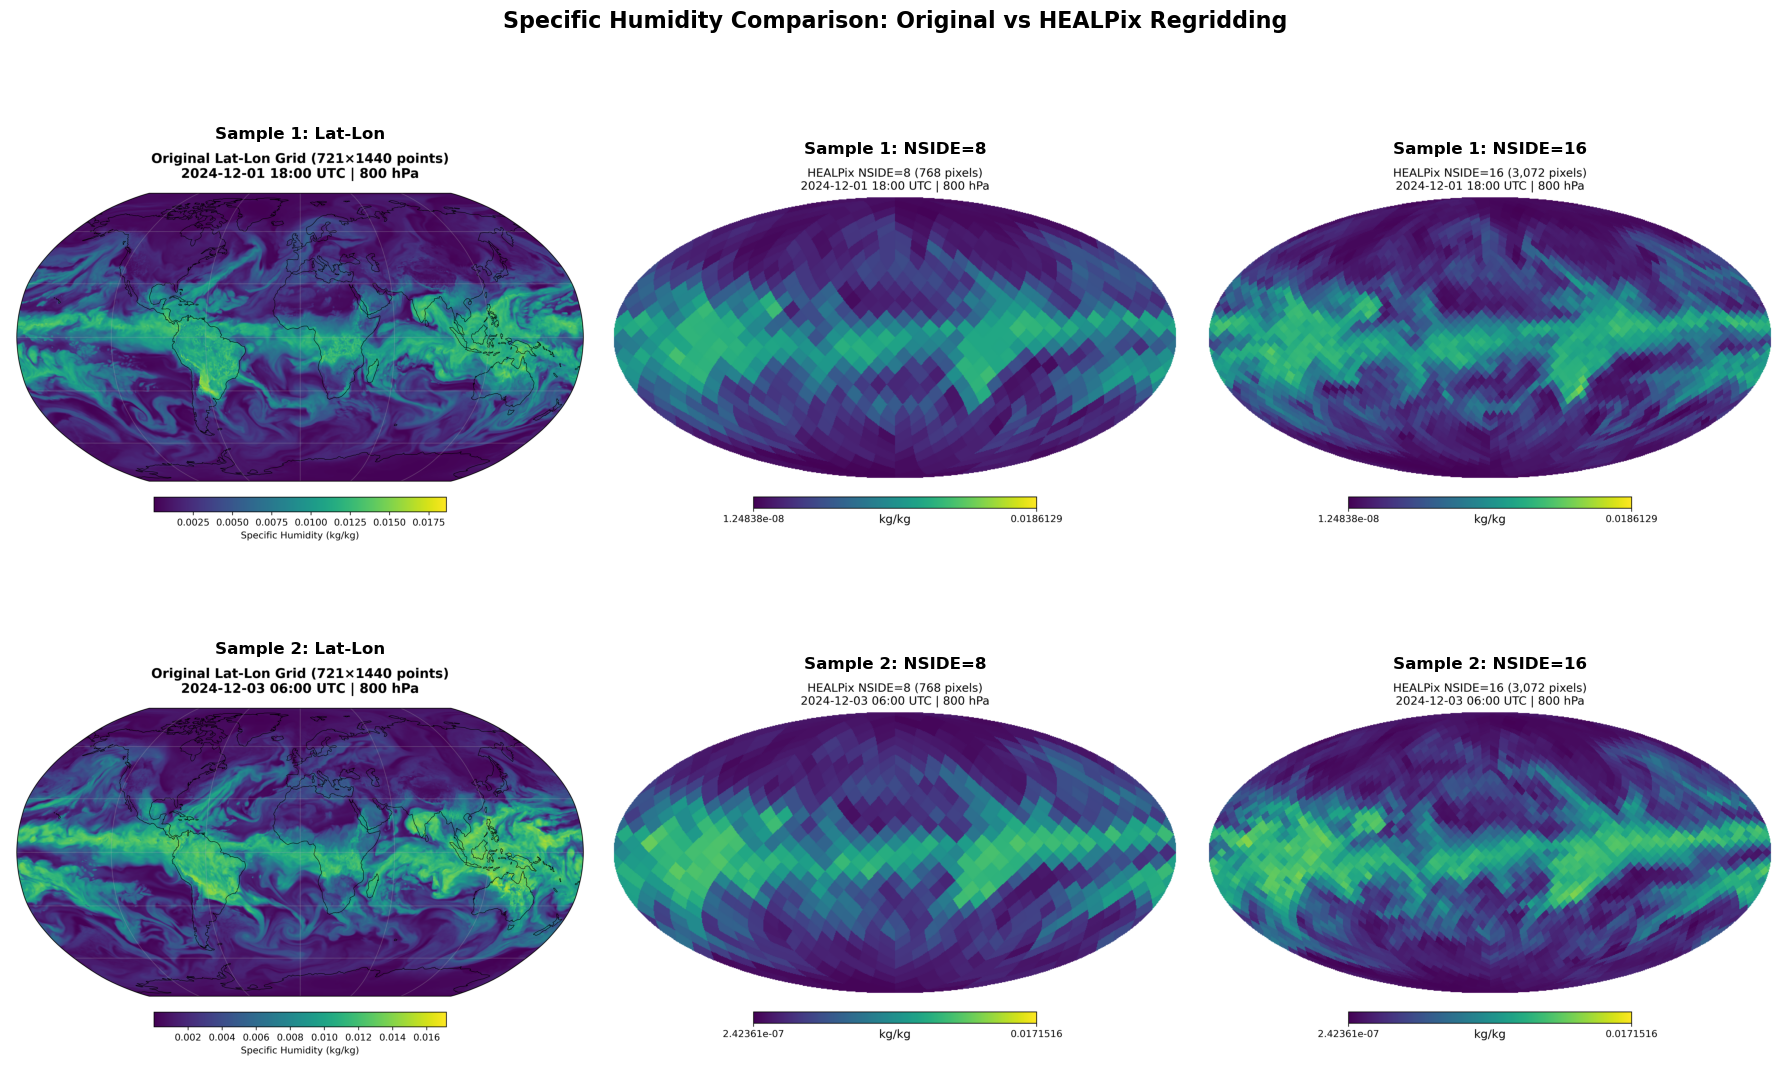

In [7]:
def display_all_samples_matplotlib():
    """Display all plots using matplotlib subplots."""
    fig = plt.figure(figsize=(18, 12))
    
    all_files = files_sample1 + files_sample2
    titles = [
        'Sample 1: Lat-Lon', 'Sample 1: NSIDE=8', 'Sample 1: NSIDE=16',
        'Sample 2: Lat-Lon', 'Sample 2: NSIDE=8', 'Sample 2: NSIDE=16'
    ]
    
    for idx, (img_file, title) in enumerate(zip(all_files, titles), 1):
        ax = plt.subplot(2, 3, idx)
        img = PILImage.open(img_file)
        ax.imshow(img)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.axis('off')
    
    plt.suptitle('Specific Humidity Comparison: Original vs HEALPix Regridding', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

display_all_samples_matplotlib()